In [2]:
import tools
import ros
import math
import numpy as np
import matplotlib.pyplot as plt
import tf
import random


In [1]:
# EKF with just GPS 
class ekf:
    def __init__(self, hz):

        self.Q = np.diag([
            0.3,  # variance of location on x-axis | this is really the SD, and same for below, no?
            0.3,  # variance of location on y-axis
            np.deg2rad(25.0),  # variance of yaw angle
            0.5  # variance of velocity
        ]) ** 2  # predict state covariance

        self.R = np.diag([1.3, 1.3, 0.05]) ** 2 # Assuming that the SD is in Metres? 

        self.dt = 1.0/hz    # window of time to which a set of measurements applies
        self.hz = hz
        #self.GPSVisualiser = GPSVisualiser()
        #self.odomPublisher = odomPublisher()

    def motion_model(self, x, u):
        """ Predict then next state of the system given the past state and a model
        :param x: [x, y, yaw, v],
        :param u: [[v]
                [yawrate]]
        :return:
        """
        F = np.array([[1.0, 0, 0, 0],
                      [0, 1.0, 0, 0],
                      [0, 0, 1.0, 0],
                      [0, 0, 0, 0]])
        # dimensions are 4 x 2. 
        # so u.T is 2 x 1. Makes sense, ends up w 4x1.
        B = np.array([[self.dt * math.cos(x[2, 0]), 0], # time interval by cosine of yaw. Essentially the horizontal distance component of the velocity vector, when the velocity is 1 at the current orientation.  
                      [self.dt * math.sin(x[2, 0]), 0], # vertical distance component, but why in this matrix form?
                      [0.0, self.dt],   # time interval
                      [1.0, 0.0]])  # to set velocity to the new velocity? 
        x1 = np.matmul(F, x)    # keep position and yaw, but remove velocity. 
        x2 = np.matmul(B, u.T)  # Get the change in x and y, and the change in yaw, as well as the new velocity.
        # updates the x, y and yaw according to the motion model
        return x1+x2

    def observation_model(self, x):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ])

        z = np.matmul(H, x)

        return z

    def jacobF(self, x, u):
        """
        Jacobian of Motion Model
        motion model
        x_{t+1} = x_t+v*dt*cos(yaw)
        y_{t+1} = y_t+v*dt*sin(yaw)
        yaw_{t+1} = yaw_t+omega*dt
        v_{t+1} = v{t}
        so
        dx/dyaw = -v*dt*sin(yaw)
        dx/dv = dt*cos(yaw)
        dy/dyaw = v*dt*cos(yaw)
        dy/dv = dt*sin(yaw) 
        """
        yaw = x[2, 0]
        v = u[0, 0]
        jF = np.array([
            [1.0, 0.0, -self.dt * v * math.sin(yaw), self.dt * math.cos(yaw)],
            [0.0, 1.0, self.dt * v * math.cos(yaw), self.dt * math.sin(yaw)],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]])

        return jF

    def jacobH(self, x):
        # Jacobian of Observation Model
        jH = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ])

        return jH

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: GPS with noise
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update
        jH = self.jacobH(xPred) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred)   # Here we predict the measurements based on our xPred. 
        y = z - zPred.T # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        return xEst, PEst   

    def runFilter(self, visualizeGps=False):
        x = np.zeros((4, 1))
        x_real = np.zeros((4, 1))
        p = np.eye(4)
        rate = 10

        estimate_data = ([],[])
        true_data = [[],[]]
        gps_data = [[], []]
        u = np.array([[10,0]])#np.deg2rad(10)/self.dt]])
        for _ in range(1000):
            x_real, x_update = self.simulateFakeDataMeasurement(x_real[0],x_real[1],x_real[2], u) 
            z = x_update.T

            x, p = self.ekf_estimation(x, p, z, u)

            u = np.array([[u[0,0] + 0.1,np.deg2rad(10)/self.dt]])

            estimate_data[0].append(x[0,0])
            estimate_data[1].append(x[1,0])
            true_data[0].append(x_real[0])
            true_data[1].append(x_real[1])
            gps_data[0].append(x_update[0])
            gps_data[1].append(x_update[1])

        return estimate_data, true_data, gps_data

    def simulateFakeDataMeasurement(self,x,y,theta,u):
        """
        I want the rover to move in circles.
        """
        x_pos_real = x + u[0,0] * self.dt * math.cos(theta) + np.random.normal(0, 0.3)
        x_pos = x_pos_real + np.random.normal(0, 1.3)# previous x plus a movement plus noise (from measurement)
        y_pos_real = y + u[0,0] * self.dt * math.sin(theta) + np.random.normal(0, 0.3)
        y_pos = y_pos_real + np.random.normal(0, 1.3)# previous y plus a movement plus noise (from measurement)
        theta_pos = theta + u[0,1] * self.dt # increases by 10 degrees 
        
        return np.array([x_pos_real, y_pos_real, theta_pos]), np.array([x_pos, y_pos, theta_pos])   

if __name__ == '__main__':
    EKF = ekf(10)
    est_data, true_data, gps_data = EKF.runFilter()
    plt.plot(gps_data[0], gps_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and GPS measurement (blue)")
    plt.figure()
    plt.plot(est_data[0], est_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and Kalman filter position estimate (blue)")

    print("Average error per time-step with position and AR tag distances: ")
   

    # compute some form of the RMSE for the kalman estimate and for the GPS only estimate. 
    avg_error_kalman = np.average(((np.array(est_data[0]) - np.squeeze(np.array(true_data[0])))**2)) + np.average(((np.array(est_data[1]) - np.squeeze(np.array(true_data[1])))**2))

    avg_error_gps = np.average(((np.array(gps_data[0]) - np.array(true_data[0]))**2)) + np.average(((np.array(gps_data[1]) - np.array(true_data[1]))**2))
    print("Kalman, no AR: ", avg_error_kalman)
    print("Pose only: ", avg_error_gps)


NameError: name 'np' is not defined

Average error per time-step with position and AR tag distances: 
Kalman, + AR:  0.34509246384295444
Pose only:  1.6652153378924415


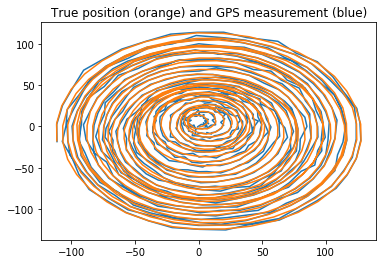

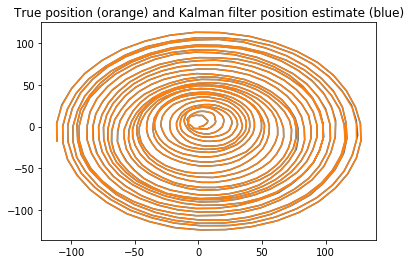

In [5]:
# EKF with AR tag data.  
arx0 = 0
ary0 = 0
arx1 = 10
ary1 = 0
arx2 = 10
ary2 = 10
P_AR_OBSERVED = 0.7
ERROR_AR = 0.1
class ekf:
    def __init__(self, hz):

        self.Q = np.diag([
            0.3,  # variance of location on x-axis | this is really the SD, and same for below, no?
            0.3,  # variance of location on y-axis
            np.deg2rad(25.0),  # variance of yaw angle
            0.5  # variance of velocity
        ]) ** 2  # predict state covariance

        self.R = np.diag([1.3, 1.3, 0.5, ERROR_AR, ERROR_AR, ERROR_AR]) ** 2 # Assuming that the SD is in Metres? 

        self.dt = 1.0/hz    # window of time to which a set of measurements applies
        self.hz = hz
        #self.GPSVisualiser = GPSVisualiser()
        #self.odomPublisher = odomPublisher()

    def motion_model(self, x, u):
        """ Predict then next state of the system given the past state and a model
        :param x: [x, y, yaw, v],
        :param u: [[v]
                [yawrate]]
        :return:
        """
        F = np.array([[1.0, 0, 0, 0],
                      [0, 1.0, 0, 0],
                      [0, 0, 1.0, 0],
                      [0, 0, 0, 0]])
              
        # dimensions are 4 x 2. 
        # so u.T is 2 x 1. Makes sense, ends up w 4x1.
        B = np.array([[self.dt * math.cos(x[2, 0]), 0], # time interval by cosine of yaw. Essentially the horizontal distance component of the velocity vector, when the velocity is 1 at the current orientation.  
                      [self.dt * math.sin(x[2, 0]), 0], # vertical distance component, but why in this matrix form?
                      [0.0, self.dt],   # time interval
                      [1.0, 0.0]])  # to set velocity to the new velocity? 
        x1 = np.matmul(F, x)    # keep position and yaw, but remove velocity. 
        x2 = np.matmul(B, u.T)  # Get the change in x and y, and the change in yaw, as well as the new velocity.
        # updates the x, y and yaw according to the motion model
        return x1+x2

    
    def observation_model2(self, x, z_a):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ])

        z = np.matmul(H, x)

        return z

    def observation_model(self, x, z_available):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        z = np.array([[x[0,0], x[1,0], x[2,0], 
            math.sqrt((x[0,0] - arx0)**2 + (x[1,0] - ary0)**2), 
            math.sqrt((x[0,0] - arx1)**2 + (x[1,0] - ary1)**2),
            math.sqrt((x[0,0] - arx2)**2 + (x[1,0] - ary2)**2)]])

        return z[:, z_available].T
    
    def jacobF(self, x, u):
        """
        Jacobian of Motion Model
        motion model
        x_{t+1} = x_t+v*dt*cos(yaw)
        y_{t+1} = y_t+v*dt*sin(yaw)
        yaw_{t+1} = yaw_t+omega*dt
        v_{t+1} = v{t}
        so
        dx/dyaw = -v*dt*sin(yaw)
        dx/dv = dt*cos(yaw)
        dy/dyaw = v*dt*cos(yaw)
        dy/dv = dt*sin(yaw) 
        """
        yaw = x[2, 0]
        v = u[0, 0]
        jF = np.array([
            [1.0, 0.0, -self.dt * v * math.sin(yaw), self.dt * math.cos(yaw)],
            [0.0, 1.0, self.dt * v * math.cos(yaw), self.dt * math.sin(yaw)],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]])

        return jF

    def jacobH(self, x, z_available):
        # Jacobian of Observation Model
        """
        x,y,yaw,d0,d1,d2,a0,a1,a2
        [1,0,0,0]
        [0,1,0,0]
        [0,0,1,0]
        ((x-d0x)^2 + (y-d0y)^2)^1/2
        ((x-d1x)^2 + (y-d1y)^2)^1/2
        ((x-d2x)^2 + (y-d2y)^2)^1/2
        
        """
        jH = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [(x[0,0]-arx0)/math.sqrt((x[0,0]-arx0)**2 + (x[1,0]-ary0)**2),(x[1,0]-ary0)/math.sqrt((x[0,0]-arx0)**2 + (x[1,0]-ary0)**2),0,0], #AR tag 0 d 
            [(x[0,0]-arx1)/math.sqrt((x[0,0]-arx1)**2 + (x[1,0]-ary1)**2),(x[1,0]-ary1)/math.sqrt((x[0,0]-arx1)**2 + (x[1,0]-ary1)**2),0,0], #AR tag 1 d
            [(x[0,0]-arx2)/math.sqrt((x[0,0]-arx2)**2 + (x[1,0]-ary2)**2),(x[1,0]-ary2)/math.sqrt((x[0,0]-arx2)**2 + (x[1,0]-ary2)**2),0,0] #AR tag 2 d

        ])

        return jH[z_available]

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(np.float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        return xEst, PEst   

    def runFilter(self, visualizeGps=False):
        x = np.zeros((4, 1))
        x_real = np.zeros((4, 1))
        p = np.eye(4)
        rate = 10

        estimate_data = ([],[])
        true_data = [[],[]]
        gps_data = [[], []]
        u = np.array([[10,np.deg2rad(10)/self.dt]])
        for _ in range(1000):
            x_real, x_update = self.simulateFakeDataMeasurement(x_real[0],x_real[1],x_real[2], u) 
            z = x_update.T

            x, p = self.ekf_estimation(x, p, z, u)

            u = np.array([[u[0,0]+0.2,np.deg2rad(10)/self.dt]])

            estimate_data[0].append(x[0,0])
            estimate_data[1].append(x[1,0])
            true_data[0].append(x_real[0])
            true_data[1].append(x_real[1])
            gps_data[0].append(x_update[0])
            gps_data[1].append(x_update[1])

        return estimate_data, true_data, gps_data

    def simulateFakeDataMeasurement(self,x,y,theta,u):
        """
        I want the rover to move in circles.
        """
        x_pos_real = x + u[0,0] * self.dt * math.cos(theta) + np.random.normal(0, 0.3)
        x_pos = x_pos_real + np.random.normal(0, 1.3)# previous x plus a movement plus noise (from measurement)
        y_pos_real = y + u[0,0] * self.dt * math.sin(theta) + np.random.normal(0, 0.3)
        y_pos = y_pos_real + np.random.normal(0, 1.3)# previous y plus a movement plus noise (from measurement)
        theta_pos_real = theta + u[0,1] * self.dt # increases by 10 degrees 
        theta_pos = theta_pos_real + np.random.normal(0,0.5)

        ar0d_real = None
        ar0d = None
        if random.random() < P_AR_OBSERVED:
            ar0d_real = math.sqrt((x_pos_real - arx0)**2 + (y_pos_real - ary0)**2)
            ar0d = ar0d_real + np.random.normal(0, ERROR_AR)
        
        ar1d_real = None
        ar1d = None
        if random.random() < P_AR_OBSERVED:
            ar1d_real = math.sqrt((x_pos_real - arx1)**2 + (y_pos_real - ary1)**2)
            ar1d = ar1d_real + np.random.normal(0, ERROR_AR)

        ar2d_real = None
        ar2d = None
        if random.random() < P_AR_OBSERVED:
            ar2d_real = math.sqrt((x_pos_real - arx2)**2 + (y_pos_real - ary2)**2)
            ar2d = ar2d_real + np.random.normal(0, ERROR_AR)
        

        return np.array([x_pos_real, y_pos_real, theta_pos_real, [ar0d_real], [ar1d_real], [ar2d_real]]), np.array([x_pos, y_pos, theta_pos, [ar0d], [ar1d], [ar2d]])   

if __name__ == '__main__':
    error = []
    #for i in range(0, 100, 5):
    i = 100
    P_AR_OBSERVED = i / 100
    EKF = ekf(10)
    est_data, true_data, gps_data = EKF.runFilter()
    plt.figure()
    plt.plot(gps_data[0], gps_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and GPS measurement (blue)")
    plt.figure()
    plt.plot(est_data[0], est_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and Kalman filter position estimate (blue)")

    print("Average error per time-step with position and AR tag distances: ")



        # compute some form of the RMSE for the kalman estimate and for the GPS only estimate. 
    avg_error_kalman = (np.average(((np.array(est_data[0]) - np.squeeze(np.array(true_data[0])).astype(np.float))**2)) + np.average(((np.array(est_data[1]) - np.squeeze(np.array(true_data[1])).astype(np.float))**2)))/2

    avg_error_gps = (np.average(((np.array(gps_data[0]).astype(np.float) - np.array(true_data[0]).astype(np.float))**2)) + np.average(((np.array(gps_data[1]).astype(np.float) - np.array(true_data[1]).astype(np.float))**2)))/2
    error.append(avg_error_kalman)
    print("Kalman, + AR: ", avg_error_kalman)
    print("Pose only: ", avg_error_gps)


Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 
Average error per time-step with position and AR tag distances: 


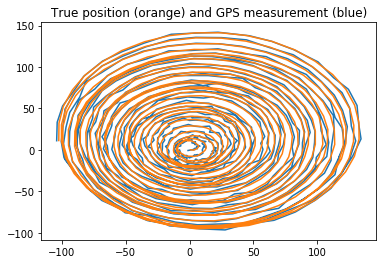

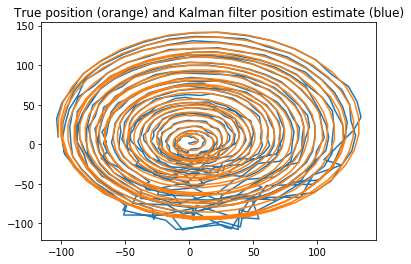

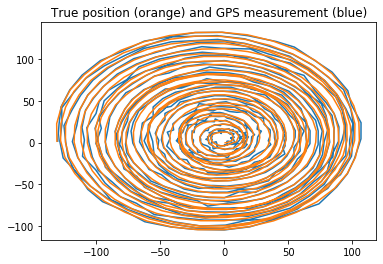

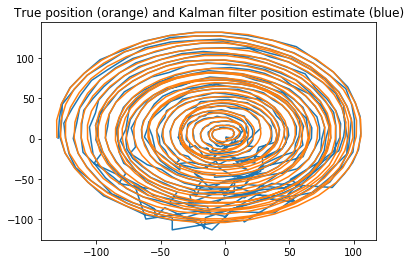

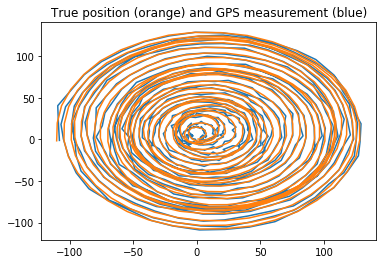

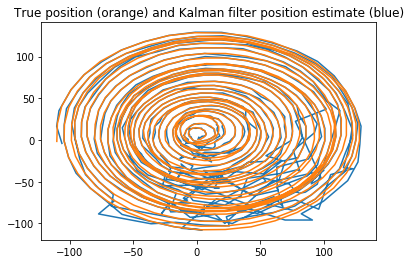

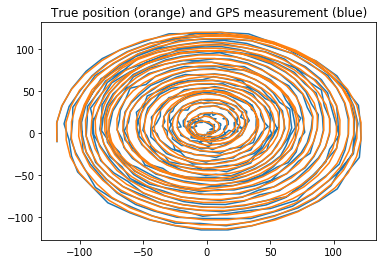

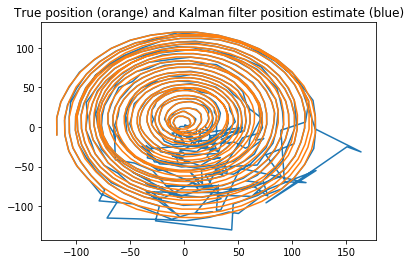

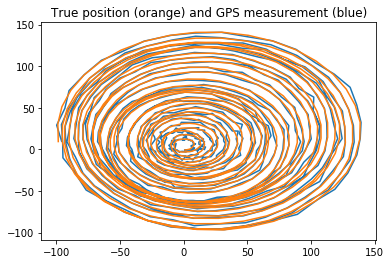

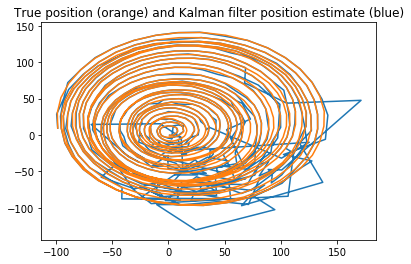

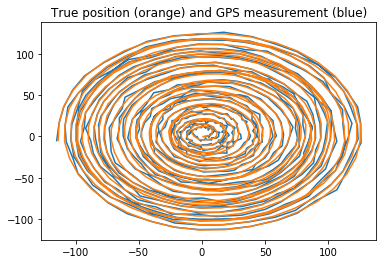

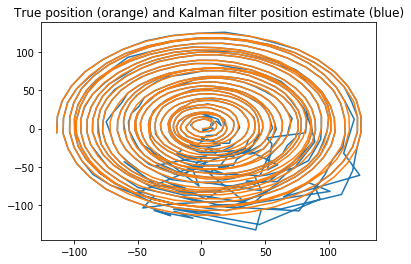

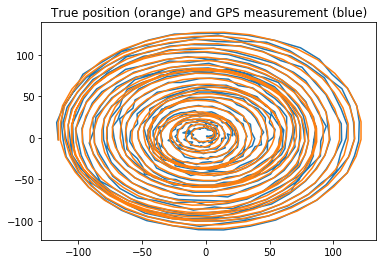

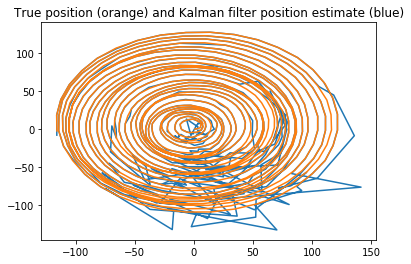

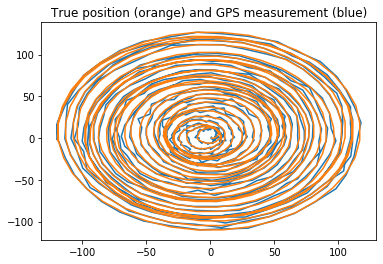

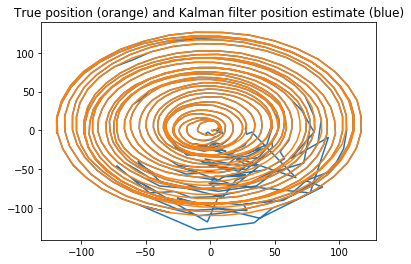

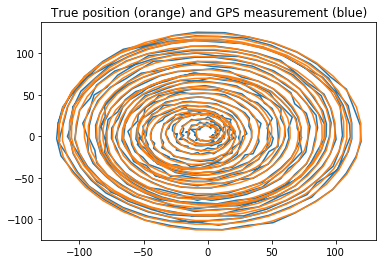

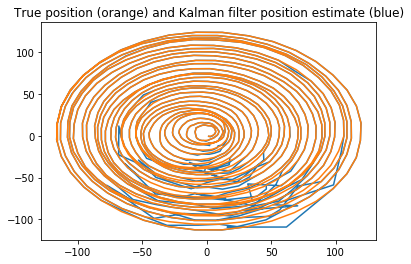

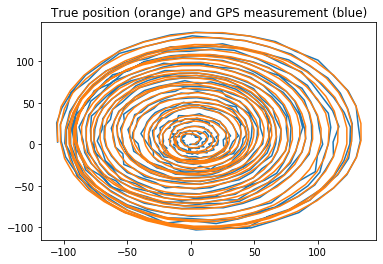

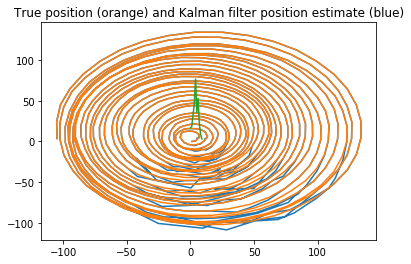

In [168]:


class Constants:
    arx0 = 0
    ary0 = 0
    arx1 = 10
    ary1 = 0
    arx2 = 10
    ary2 = 10
    P_AR_OBSERVED = 0.7
    ERROR_AR = 0.01
    ERROR_AR_ANGLE = np.deg2rad(360)
    Q = np.diag([
            0.3,  # variance of location on x-axis
            0.3,  # variance of location on y-axis
            np.deg2rad(25.0),  # variance of yaw angle
            0.5  # variance of velocity
        ]) ** 2  # predict state covariance
    
    R = np.diag([1.3, 1.3, 0.5, ERROR_AR, ERROR_AR, ERROR_AR, ERROR_AR_ANGLE,ERROR_AR_ANGLE,ERROR_AR_ANGLE]) ** 2 # Assuming that the SD is in Metres? 


class ekf:
    def __init__(self, hz,R,Q):
        assert(hz != 0)
        self.R = R
        self.Q = Q
        self.dt = 1.0/hz    # window of time to which a set of measurements applies
        self.hz = hz
        #self.GPSVisualiser = GPSVisualiser()
        #self.odomPublisher = odomPublisher()

    def motion_model(self, x, u):
        """ Predict then next state of the system given the past state and a model
        :param x: [x, y, yaw, v],
        :param u: [[v]
                [yawrate]]
        :return:
        """ 
        assert(x.shape == (4,1))
        assert(u.shape == (1,2))

        F = np.array([[1.0, 0, 0, 0],
                      [0, 1.0, 0, 0],
                      [0, 0, 1.0, 0],
                      [0, 0, 0, 0]])
              
        # dimensions are 4 x 2. 
        # so u.T is 2 x 1. Makes sense, ends up w 4x1.
        B = np.array([[self.dt * math.cos(x[2, 0]), 0], # time interval by cosine of yaw. Essentially the horizontal distance component of the velocity vector, when the velocity is 1 at the current orientation.  
                      [self.dt * math.sin(x[2, 0]), 0], # vertical distance component, but why in this matrix form?
                      [0.0, self.dt],   # time interval
                      [1.0, 0.0]])  # to set velocity to the new velocity? 
        x1 = np.matmul(F, x)    # keep position and yaw, but remove velocity. 
        x2 = np.matmul(B, u.T)  # Get the change in x and y, and the change in yaw, as well as the new velocity.
        # updates the x, y and yaw according to the motion model
        retval = x1+x2
        # make sure that the yaw is between 0 - 2pi
        retval[2] = retval[2]%(2*math.pi)
        #retval[2] = retval[2] if retval[2] >= 0 else 2 * math.pi + retval[2]
        return retval

    def observation_model(self, x, z_available):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        ar0Theta = np.arctan2(Constants.arx0 - x[0,0], Constants.ary0 - x[1,0])
        ar0Theta = (ar0Theta if ar0Theta >= 0 else 2 * math.pi + ar0Theta)
        ar1Theta = np.arctan2(Constants.arx1 - x[0,0], Constants.ary1 - x[1,0])
        ar1Theta = (ar1Theta if ar1Theta >= 0 else 2 * math.pi + ar1Theta)
        ar2Theta = np.arctan2(Constants.arx2 - x[0,0], Constants.ary2 - x[1,0])
        ar2Theta =  (ar2Theta if ar2Theta >= 0 else 2 * math.pi + ar2Theta)

        z = np.array([[x[0,0], x[1,0], x[2,0], 
            math.sqrt((x[0,0] - Constants.arx0)**2 + (x[1,0] - Constants.ary0)**2), 
            math.sqrt((x[0,0] - Constants.arx1)**2 + (x[1,0] - Constants.ary1)**2),
            math.sqrt((x[0,0] - Constants.arx2)**2 + (x[1,0] - Constants.ary2)**2),
            ar0Theta - x[2,0] if ar0Theta - x[2,0] >= 0 else ar0Theta - x[2,0] + 2*math.pi,
            ar1Theta - x[2,0] if ar1Theta - x[2,0] >= 0 else ar1Theta - x[2,0] + 2*math.pi,
            ar2Theta - x[2,0] if ar2Theta - x[2,0] >= 0 else ar2Theta - x[2,0] + 2*math.pi
            ]])

        
        return z[:, z_available].T
    
    def jacobF(self, x, u):
        """
        Jacobian of Motion Model
        motion model
        x_{t+1} = x_t+v*dt*cos(yaw)
        y_{t+1} = y_t+v*dt*sin(yaw)
        yaw_{t+1} = yaw_t+omega*dt
        v_{t+1} = v{t}
        so
        dx/dyaw = -v*dt*sin(yaw)
        dx/dv = dt*cos(yaw)
        dy/dyaw = v*dt*cos(yaw)
        dy/dv = dt*sin(yaw) 
        """
        yaw = x[2, 0]
        v = u[0, 0]
        jF = np.array([
            [1.0, 0.0, -self.dt * v * math.sin(yaw), self.dt * math.cos(yaw)],
            [0.0, 1.0, self.dt * v * math.cos(yaw), self.dt * math.sin(yaw)],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]])

        return jF

    def jacobH(self, x, z_available):
        # Jacobian of Observation Model
        """
        x,y,yaw,d0,d1,d2,a0,a1,a2
        [1,0,0,0]
        [0,1,0,0]
        [0,0,1,0]
        ((x-d0x)^2 + (y-d0y)^2)^1/2
        ((x-d1x)^2 + (y-d1y)^2)^1/2
        ((x-d2x)^2 + (y-d2y)^2)^1/2
        (np.arctan2(Constants.arx0 - x, Constants.ary0 - y) - yaw
        So the derivative in terms of x is: 
        """
        jH = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [(x[0,0]-Constants.arx0)/math.sqrt((x[0,0]-Constants.arx0)**2 + (x[1,0]-Constants.ary0)**2),(x[1,0]-Constants.ary0)/math.sqrt((x[0,0]-Constants.arx0)**2 + (x[1,0]-Constants.ary0)**2),0,0], #AR tag 0 d 
            [(x[0,0]-Constants.arx1)/math.sqrt((x[0,0]-Constants.arx1)**2 + (x[1,0]-Constants.ary1)**2),(x[1,0]-Constants.ary1)/math.sqrt((x[0,0]-Constants.arx1)**2 + (x[1,0]-Constants.ary1)**2),0,0], #AR tag 1 d
            [(x[0,0]-Constants.arx2)/math.sqrt((x[0,0]-Constants.arx2)**2 + (x[1,0]-Constants.ary2)**2),(x[1,0]-Constants.ary2)/math.sqrt((x[0,0]-Constants.arx2)**2 + (x[1,0]-Constants.ary2)**2),0,0], #AR tag 2 d

            [-(Constants.ary0 - x[1,0])/((Constants.ary0 - x[1,0])**2 + (Constants.arx0 - x[0,0])**2),(Constants.arx0 - x[0,0])/((Constants.ary0 - x[1,0])**2 + (Constants.arx0 - x[0,0])**2), 0, -1],
            [-(Constants.ary1 - x[1,0])/((Constants.ary1 - x[1,0])**2 + (Constants.arx1 - x[0,0])**2),(Constants.arx1 - x[0,0])/((Constants.ary1 - x[1,0])**2 + (Constants.arx1 - x[0,0])**2), 0, -1],
            [-(Constants.ary2 - x[1,0])/((Constants.ary2 - x[1,0])**2 + (Constants.arx2 - x[0,0])**2),(Constants.arx2 - x[0,0])/((Constants.ary2 - x[1,0])**2 + (Constants.arx2 - x[0,0])**2), 0, -1]
        ])

        return jH[z_available]

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(np.float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        # gross boundConstants.ary checkup on the yaw to keep it positive, gotta figure out a better way
        xEst[2] = (xEst[2]) % (2 * math.pi)
        #xEst[2] = xEst[2] if xEst[2] >= 0 else 2 * math.pi + xEst[2]
        return xEst, PEst 

    def runFilter(self, visualizeGps=False):
        x1 = np.zeros((4, 1))
        x_real = np.zeros((4, 1))
        p1 = np.eye(4)
        rate = 10

        estimate_data = ([],[])
        true_data = [[],[]]
        gps_data = [[], []]
        u = np.array([[10,np.deg2rad(10)/self.dt]])
        for _ in range(1000):
            x_real, x_update = self.simulateFakeDataMeasurement(x_real[0],x_real[1],x_real[2], u) 
            z = x_update.T

            x1, p1 = self.ekf_estimation(x1, p1, z, u)
            #x2, p2 = self.ekf_estimation2(x2,p2,z,u)
            
            u = np.array([[u[0,0] + 0.2,np.deg2rad(10)/self.dt]])

            estimate_data[0].append(x1[0,0])
            estimate_data[1].append(x1[1,0])
            true_data[0].append(x_real[0])
            true_data[1].append(x_real[1])
            gps_data[0].append(x_update[0])
            gps_data[1].append(x_update[1])

        return estimate_data, true_data, gps_data

    def simulateFakeDataMeasurement(self,x,y,theta,u):
        """
        I want the rover to move in circles.
        """
        x_pos_real = x + u[0,0] * self.dt * math.cos(theta) + np.random.normal(0, 0.3)
        x_pos = x_pos_real + np.random.normal(0, 1.3)# previous x plus a movement plus noise (from measurement)
        y_pos_real = y + u[0,0] * self.dt * math.sin(theta) + np.random.normal(0, 0.3)
        y_pos = y_pos_real + np.random.normal(0, 1.3)# previous y plus a movement plus noise (from measurement)
        theta_pos_real = (theta + u[0,1] * self.dt) % (2 * math.pi)# increases by 10 degrees 
        theta_pos = (theta_pos_real + np.random.normal(0,0.5)) % (2 * math.pi)

        ar0d_real = None
        ar0d = None
        ar0A_real = None
        ar0A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar0d_real = math.sqrt((x_pos_real - Constants.arx0)**2 + (y_pos_real - Constants.ary0)**2)
            ar0d = ar0d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx0 - x_pos_real[0], Constants.ary0 - y_pos_real[0])
            #ar0A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar0A = ar0A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)
        
        ar1d_real = None
        ar1d = None
        ar1A_real = None
        ar1A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar1d_real = math.sqrt((x_pos_real - Constants.arx1)**2 + (y_pos_real - Constants.ary1)**2)
            ar1d = ar1d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx1 - x_pos_real[0], Constants.ary1 - y_pos_real[0])
            #ar1A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar1A = ar1A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)

        ar2d_real = None
        ar2d = None
        ar2A_real = None
        ar2A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar2d_real = math.sqrt((x_pos_real - Constants.arx2)**2 + (y_pos_real - Constants.ary2)**2)
            ar2d = ar2d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx2 - x_pos_real[0], Constants.ary2 - y_pos_real[0])
            #ar2A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar2A = ar2A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)


        return np.array([x_pos_real, y_pos_real, theta_pos_real, [ar0d_real], [ar1d_real], [ar2d_real], [ar0A_real], [ar1A_real], [ar2A_real]]), np.array([x_pos, y_pos, theta_pos, [ar0d], [ar1d], [ar2d], [ar0A], [ar1A], [ar2A]])   

if __name__ == '__main__':
    error = []
    for i in range(0, 100, 10):
        Constants.P_AR_OBSERVED = i/100
        EKF = ekf(10, Constants.R, Constants.Q)
        est_data, true_data, gps_data = EKF.runFilter()
        plt.figure()
        plt.plot(gps_data[0], gps_data[1])
        plt.plot(true_data[0], true_data[1])
        plt.title("True position (orange) and GPS measurement (blue)")
        plt.figure()
        plt.plot(est_data[0], est_data[1])
        plt.plot(true_data[0], true_data[1])
        plt.title("True position (orange) and Kalman filter position estimate (blue)")

        print("Average error per time-step with position and AR tag distances: ")

        # compute some form of the RMSE for the kalman estimate and for the GPS only estimate. 
        avg_error_kalman = (np.average(((np.array(est_data[0]) - np.squeeze(np.array(true_data[0])).astype(np.float))**2)) + np.average(((np.array(est_data[1]) - np.squeeze(np.array(true_data[1])).astype(np.float))**2)))/2

        avg_error_gps = (np.average(((np.array(gps_data[0]).astype(np.float) - np.array(true_data[0]).astype(np.float))**2)) + np.average(((np.array(gps_data[1]).astype(np.float) - np.array(true_data[1]).astype(np.float))**2)))/2
        error.append(avg_error_kalman)
    plt.plot(error)
    #print("Kalman, no AR: ", avg_error_kalman)
    #print("Pose only: ", avg_error_gps)


4]
 [10.92185509]
 [ 3.87924219]
 [14.3488373 ]]
PREVP1:  [[ 9.38561851e-05  6.97125275e-05 -2.31621510e-06 -1.78732509e-04]
 [ 6.97125275e-05  1.31930960e-04 -1.99079027e-05 -1.98511531e-04]
 [-2.31621510e-06 -1.99079028e-05  1.17620774e-01  1.72781401e-05]
 [-1.78732509e-04 -1.98511531e-04  1.72781401e-05  1.63038058e+00]]
Z:  [[-5.792028064889447 7.963910032006033 4.490487050228032
  11.463120815535726 18.571811591006938 15.65347941356843 None None None]]
U:  [[14.6         1.74532925]]


REAL:  [[-6.278928137630787]
 [8.424496906457986]
 [4.380776422505765]
 [10.507001793302017]
 [18.329638551730024]
 [16.354990409899596]
 [None]
 [None]
 [None]]
Estimate:  [[-6.27551155]
 [ 8.4283816 ]
 [ 4.96572227]
 [15.12220299]]
PREV:  [[-5.65684729]
 [ 9.97783299]
 [ 4.1870018 ]
 [14.84581558]]
PREVP1:  [[ 8.16614498e-05  6.62169818e-05  6.42515681e-06 -1.56874728e-04]
 [ 6.62169818e-05  1.46978029e-04 -1.00481461e-05 -2.40276275e-04]
 [ 6.42515683e-06 -1.00481462e-05  1.17436792e-01  9.39340

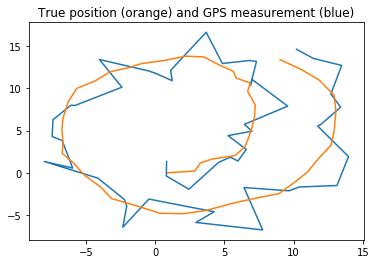

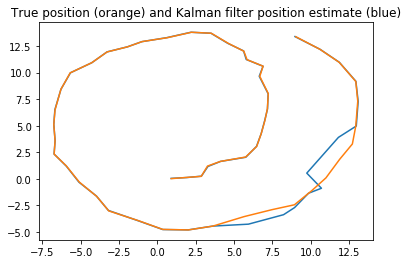

In [223]:
# EKF with AR tag data.  
import math
import numpy as np
import matplotlib.pyplot as plt
import tf
import random


class Constants:
    arx0 = 0
    ary0 = 0
    arx1 = 10
    ary1 = 0
    arx2 = 10
    ary2 = 10
    P_AR_OBSERVED = 0.7
    ERROR_AR = 0.01
    ERROR_AR_ANGLE = np.deg2rad(360)
    Q = np.diag([
            0.3,  # variance of location on x-axis
            0.3,  # variance of location on y-axis
            np.deg2rad(25.0),  # variance of yaw angle
            0.5  # variance of velocity
        ]) ** 2  # predict state covariance
    
    R = np.diag([1.3, 1.3, 0.5, ERROR_AR, ERROR_AR, ERROR_AR, ERROR_AR_ANGLE,ERROR_AR_ANGLE,ERROR_AR_ANGLE]) ** 2 # Assuming that the SD is in Metres? 


class ekf:
    def __init__(self, hz,R,Q):
        assert(hz != 0)
        self.R = R
        self.Q = Q
        self.dt = 1.0/hz    # window of time to which a set of measurements applies
        self.hz = hz
        #self.GPSVisualiser = GPSVisualiser()
        #self.odomPublisher = odomPublisher()

    def motion_model(self, x, u):
        """ Predict then next state of the system given the past state and a model
        :param x: [x, y, yaw, v],
        :param u: [[v]
                [yawrate]]
        :return:
        """ 
        assert(x.shape == (4,1))
        assert(u.shape == (1,2))

        F = np.array([[1.0, 0, 0, 0],
                      [0, 1.0, 0, 0],
                      [0, 0, 1.0, 0],
                      [0, 0, 0, 0]])
              
        # dimensions are 4 x 2. 
        # so u.T is 2 x 1. Makes sense, ends up w 4x1.
        B = np.array([[self.dt * math.cos(x[2, 0]), 0], # time interval by cosine of yaw. Essentially the horizontal distance component of the velocity vector, when the velocity is 1 at the current orientation.  
                      [self.dt * math.sin(x[2, 0]), 0], # vertical distance component, but why in this matrix form?
                      [0.0, self.dt],   # time interval
                      [1.0, 0.0]])  # to set velocity to the new velocity? 
        x1 = np.matmul(F, x)    # keep position and yaw, but remove velocity. 
        x2 = np.matmul(B, u.T)  # Get the change in x and y, and the change in yaw, as well as the new velocity.
        # updates the x, y and yaw according to the motion model
        retval = x1+x2
        # make sure that the yaw is between 0 - 2pi
        retval[2] = retval[2]%(2*math.pi)
        #retval[2] = retval[2] if retval[2] >= 0 else 2 * math.pi + retval[2]
        return retval

    def observation_model(self, x, z_available):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        ar0Theta = np.arctan2(Constants.arx0 - x[0,0], Constants.ary0 - x[1,0])
        ar0Theta = (ar0Theta if ar0Theta >= 0 else 2 * math.pi + ar0Theta)
        ar1Theta = np.arctan2(Constants.arx1 - x[0,0], Constants.ary1 - x[1,0])
        ar1Theta = (ar1Theta if ar1Theta >= 0 else 2 * math.pi + ar1Theta)
        ar2Theta = np.arctan2(Constants.arx2 - x[0,0], Constants.ary2 - x[1,0])
        ar2Theta =  (ar2Theta if ar2Theta >= 0 else 2 * math.pi + ar2Theta)

        z = np.array([[x[0,0], x[1,0], x[2,0], 
            math.sqrt((x[0,0] - Constants.arx0)**2 + (x[1,0] - Constants.ary0)**2), 
            math.sqrt((x[0,0] - Constants.arx1)**2 + (x[1,0] - Constants.ary1)**2),
            math.sqrt((x[0,0] - Constants.arx2)**2 + (x[1,0] - Constants.ary2)**2),
            ar0Theta - x[2,0] if ar0Theta - x[2,0] >= 0 else ar0Theta - x[2,0] + 2*math.pi,
            ar1Theta - x[2,0] if ar1Theta - x[2,0] >= 0 else ar1Theta - x[2,0] + 2*math.pi,
            ar2Theta - x[2,0] if ar2Theta - x[2,0] >= 0 else ar2Theta - x[2,0] + 2*math.pi
            ]])

        
        return z[:, z_available].T
    
    def jacobF(self, x, u):
        """
        Jacobian of Motion Model
        motion model
        x_{t+1} = x_t+v*dt*cos(yaw)
        y_{t+1} = y_t+v*dt*sin(yaw)
        yaw_{t+1} = yaw_t+omega*dt
        v_{t+1} = v{t}
        so
        dx/dyaw = -v*dt*sin(yaw)
        dx/dv = dt*cos(yaw)
        dy/dyaw = v*dt*cos(yaw)
        dy/dv = dt*sin(yaw) 
        """
        yaw = x[2, 0]
        v = u[0, 0]
        jF = np.array([
            [1.0, 0.0, -self.dt * v * math.sin(yaw), self.dt * math.cos(yaw)],
            [0.0, 1.0, self.dt * v * math.cos(yaw), self.dt * math.sin(yaw)],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]])

        return jF

    def jacobH(self, x, z_available):
        # Jacobian of Observation Model
        """
        x,y,yaw,d0,d1,d2,a0,a1,a2
        [1,0,0,0]
        [0,1,0,0]
        [0,0,1,0]
        ((x-d0x)^2 + (y-d0y)^2)^1/2
        ((x-d1x)^2 + (y-d1y)^2)^1/2
        ((x-d2x)^2 + (y-d2y)^2)^1/2
        (np.arctan2(Constants.arx0 - x, Constants.ary0 - y) - yaw
        So the derivative in terms of x is: 
        """
        jH = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [(x[0,0]-Constants.arx0)/math.sqrt((x[0,0]-Constants.arx0)**2 + (x[1,0]-Constants.ary0)**2),(x[1,0]-Constants.ary0)/math.sqrt((x[0,0]-Constants.arx0)**2 + (x[1,0]-Constants.ary0)**2),0,0], #AR tag 0 d 
            [(x[0,0]-Constants.arx1)/math.sqrt((x[0,0]-Constants.arx1)**2 + (x[1,0]-Constants.ary1)**2),(x[1,0]-Constants.ary1)/math.sqrt((x[0,0]-Constants.arx1)**2 + (x[1,0]-Constants.ary1)**2),0,0], #AR tag 1 d
            [(x[0,0]-Constants.arx2)/math.sqrt((x[0,0]-Constants.arx2)**2 + (x[1,0]-Constants.ary2)**2),(x[1,0]-Constants.ary2)/math.sqrt((x[0,0]-Constants.arx2)**2 + (x[1,0]-Constants.ary2)**2),0,0], #AR tag 2 d

            [-(Constants.ary0 - x[1,0])/((Constants.ary0 - x[1,0])**2 + (Constants.arx0 - x[0,0])**2),(Constants.arx0 - x[0,0])/((Constants.ary0 - x[1,0])**2 + (Constants.arx0 - x[0,0])**2), 0, -1],
            [-(Constants.ary1 - x[1,0])/((Constants.ary1 - x[1,0])**2 + (Constants.arx1 - x[0,0])**2),(Constants.arx1 - x[0,0])/((Constants.ary1 - x[1,0])**2 + (Constants.arx1 - x[0,0])**2), 0, -1],
            [-(Constants.ary2 - x[1,0])/((Constants.ary2 - x[1,0])**2 + (Constants.arx2 - x[0,0])**2),(Constants.arx2 - x[0,0])/((Constants.ary2 - x[1,0])**2 + (Constants.arx2 - x[0,0])**2), 0, -1]
        ])

        return jH[z_available]

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        # gross boundConstants.ary checkup on the yaw to keep it positive, gotta figure out a better way
        xEst[2] = (xEst[2]) % (2 * math.pi)
        #xEst[2] = xEst[2] if xEst[2] >= 0 else 2 * math.pi + xEst[2]
        return xEst, PEst   

    def ekf_estimation2(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        xEst[2] = (xEst[2]) % (2 * math.pi)
        return xEst, PEst   

    def runFilter(self, visualizeGps=False):
        x1 = np.zeros((4, 1))
        x_real = np.zeros((4, 1))
        p1 = np.eye(4)
        rate = 10

        estimate_data = ([],[])
        true_data = [[],[]]
        gps_data = [[], []]
        u = np.array([[10,np.deg2rad(11)/self.dt]])
        for _ in range(50):
            x_real, x_update = self.simulateFakeDataMeasurement(x_real[0],x_real[1],x_real[2], u) 
            z = x_update.T
            
            prevx1 = x1
            prevp1 = p1
            x1, p1 = self.ekf_estimation2(x1, p1, z, u)
            
            print("\n")
            print("REAL: ", x_real)
            print("Estimate: ", x1)
            print("PREV: ", prevx1)
            print("PREVP1: ", prevp1)
            print("Z: ", z)
            print("U: ", u)
            #print(x2)
            
            u = np.array([[u[0,0] + 0.2,np.deg2rad(10)/self.dt]])

            estimate_data[0].append(x1[0,0])
            estimate_data[1].append(x1[1,0])
            true_data[0].append(x_real[0])
            true_data[1].append(x_real[1])
            gps_data[0].append(x_update[0])
            gps_data[1].append(x_update[1])

        return estimate_data, true_data, gps_data

    def simulateFakeDataMeasurement(self,x,y,theta,u):
        """
        I want the rover to move in circles.
        """
        x_pos_real = x + u[0,0] * self.dt * math.cos(theta) + np.random.normal(0, 0.3)
        x_pos = x_pos_real + np.random.normal(0, 1.3)# previous x plus a movement plus noise (from measurement)
        y_pos_real = y + u[0,0] * self.dt * math.sin(theta) + np.random.normal(0, 0.3)
        y_pos = y_pos_real + np.random.normal(0, 1.3)# previous y plus a movement plus noise (from measurement)
        theta_pos_real = (theta + u[0,1] * self.dt) % (2 * math.pi)# increases by 10 degrees 
        theta_pos = (theta_pos_real + np.random.normal(0,0.5)) % (2 * math.pi)

        ar0d_real = None
        ar0d = None
        ar0A_real = None
        ar0A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar0d_real = math.sqrt((x_pos_real - Constants.arx0)**2 + (y_pos_real - Constants.ary0)**2)
            ar0d = ar0d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx0 - x_pos_real[0], Constants.ary0 - y_pos_real[0])
            #ar0A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar0A = ar0A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)
        
        ar1d_real = None
        ar1d = None
        ar1A_real = None
        ar1A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar1d_real = math.sqrt((x_pos_real - Constants.arx1)**2 + (y_pos_real - Constants.ary1)**2)
            ar1d = ar1d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx1 - x_pos_real[0], Constants.ary1 - y_pos_real[0])
            #ar1A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar1A = ar1A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)

        ar2d_real = None
        ar2d = None
        ar2A_real = None
        ar2A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar2d_real = math.sqrt((x_pos_real - Constants.arx2)**2 + (y_pos_real - Constants.ary2)**2)
            ar2d = ar2d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx2 - x_pos_real[0], Constants.ary2 - y_pos_real[0])
            #ar2A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar2A = ar2A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)


        return np.array([x_pos_real, y_pos_real, theta_pos_real, [ar0d_real], [ar1d_real], [ar2d_real], [ar0A_real], [ar1A_real], [ar2A_real]]), np.array([x_pos, y_pos, theta_pos, [ar0d], [ar1d], [ar2d], [ar0A], [ar1A], [ar2A]])   

if __name__ == '__main__':
    error = []
    #for i in range(0, 100, 5):
    Constants.P_AR_OBSERVED = 100/100
    EKF = ekf(10, Constants.R, Constants.Q)
    est_data, true_data, gps_data = EKF.runFilter()
    plt.figure()
    plt.plot(gps_data[0], gps_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and GPS measurement (blue)")
    plt.figure()
    plt.plot(est_data[0], est_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and Kalman filter position estimate (blue)")

    #print("Average error per time-step with position and AR tag distances: ")



    # compute some form of the RMSE for the kalman estimate and for the GPS only estimate. 
    avg_error_kalman = (np.average(((np.array(est_data[0]) - np.squeeze(np.array(true_data[0])).astype(float))**2)) + np.average(((np.array(est_data[1]) - np.squeeze(np.array(true_data[1])).astype(float))**2)))/2

    avg_error_gps = (np.average(((np.array(gps_data[0]).astype(float) - np.array(true_data[0]).astype(float))**2)) + np.average(((np.array(gps_data[1]).astype(float) - np.array(true_data[1]).astype(float))**2)))/2
    error.append(avg_error_kalman)

    #print("Kalman, no AR: ", avg_error_kalman)
    #print("Pose only: ", avg_error_gps)


In [241]:
 def ekf_estimation2(xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = E.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = E.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + E.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = E.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = E.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + E.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        xEst[2] = (xEst[2]) % (2 * math.pi)
        return xEst, PEst   

prevx1 = np.array([[ 2.01792803],
                [-4.79473828],
                [6.27778496],
                [16.97710831]])
print(prevx1.shape)
prevpx1 = np.array([[1.08403297*10**-4, -2.93400923*10**-5, -6.52683264*10**-6,  1.67437305*10**-4],
 [-2.93400924*10**-5,  5.95682439*10**-5,  1.46251648*10**-5, -4.75650167*10**-5],
 [-6.52683264*10**-6,  1.46251648*10**-5, 1.15576674*10**-1, -9.11047095*10**-6],
 [ 1.67437305*10**-4, -4.75650167*10**-5, -9.11047095*10**-6,  1.63052221]])

z = np.array([[2.938364956549898, -5.829428574276752, 5.43208417760029, 5.729651456309737, 7.7681136978978405, 15.777265101279973, None, None, None]])
u = np.array([[17.2,1.74532925]])


E = ekf(10, Constants.R, Constants.Q)
print(ekf_estimation2(prevx1, prevpx1, z,u))



(4, 1)
(array([[ 3.62081303],
       [-4.43850816],
       [ 2.69348967],
       [17.11738965]]), array([[ 9.17343618e-05, -1.77886311e-05, -8.15888800e-06,
         1.34070725e-04],
       [-1.77886311e-05,  5.77392462e-05,  1.48371331e-05,
        -1.19866801e-05],
       [-8.15888801e-06,  1.48371331e-05,  1.15445087e-01,
        -6.53268622e-06],
       [ 1.34070725e-04, -1.19866800e-05, -6.53268615e-06,
         1.63045132e+00]]))


Kalman:  1.2611554051024234
Pose only:  1.7549821906669303


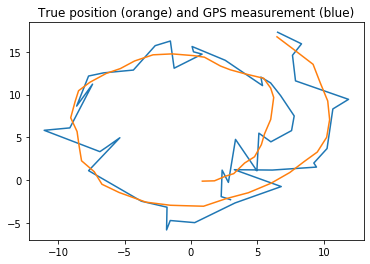

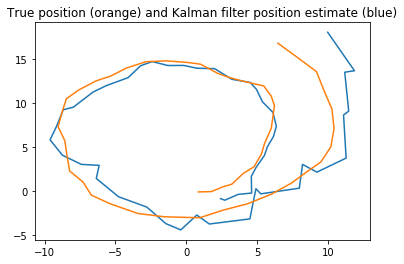

In [242]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tf
import random

# EKF with AR tag data.  
import math
import numpy as np
import matplotlib.pyplot as plt
import tf
import random


class Constants:
    arx0 = 0
    ary0 = 0
    arx1 = 10
    ary1 = 0
    arx2 = 10
    ary2 = 10
    P_AR_OBSERVED = 0.7
    ERROR_AR = 1.8
    ERROR_AR_ANGLE = np.deg2rad(360)
    Q = np.diag([
            0.3,  # variance of location on x-axis
            0.3,  # variance of location on y-axis
            np.deg2rad(25.0),  # variance of yaw angle
            0.5  # variance of velocity
        ]) ** 2  # predict state covariance
    
    R = np.diag([1.3, 1.3, 0.5, ERROR_AR, ERROR_AR, ERROR_AR, ERROR_AR_ANGLE,ERROR_AR_ANGLE,ERROR_AR_ANGLE]) ** 2 # Assuming that the SD is in Metres? 


class ekf:
    def __init__(self, hz,R,Q):
        assert(hz != 0)
        self.R = R
        self.Q = Q
        self.dt = 1.0/hz    # window of time to which a set of measurements applies
        self.hz = hz
        #self.GPSVisualiser = GPSVisualiser()
        #self.odomPublisher = odomPublisher()

    def motion_model(self, x, u):
        """ Predict then next state of the system given the past state and a model
        :param x: [x, y, yaw, v],
        :param u: [[v]
                [yawrate]]
        :return:
        """ 
        assert(x.shape == (4,1))
        assert(u.shape == (1,2))

        F = np.array([[1.0, 0, 0, 0],
                      [0, 1.0, 0, 0],
                      [0, 0, 1.0, 0],
                      [0, 0, 0, 0]])
              
        # dimensions are 4 x 2. 
        # so u.T is 2 x 1. Makes sense, ends up w 4x1.
        B = np.array([[self.dt * math.cos(x[2, 0]), 0], # time interval by cosine of yaw. Essentially the horizontal distance component of the velocity vector, when the velocity is 1 at the current orientation.  
                      [self.dt * math.sin(x[2, 0]), 0], # vertical distance component, but why in this matrix form?
                      [0.0, self.dt],   # time interval
                      [1.0, 0.0]])  # to set velocity to the new velocity? 
        x1 = np.matmul(F, x)    # keep position and yaw, but remove velocity. 
        x2 = np.matmul(B, u.T)  # Get the change in x and y, and the change in yaw, as well as the new velocity.
        # updates the x, y and yaw according to the motion model
        retval = x1+x2
        # make sure that the yaw is between 0 - 2pi
        retval[2] = retval[2]%(2*math.pi)
        #retval[2] = retval[2] if retval[2] >= 0 else 2 * math.pi + retval[2]
        return retval

    def observation_model(self, x, z_available):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        ar0Theta = np.arctan2(Constants.arx0 - x[0,0], Constants.ary0 - x[1,0])
        ar0Theta = (ar0Theta if ar0Theta >= 0 else 2 * math.pi + ar0Theta)
        ar1Theta = np.arctan2(Constants.arx1 - x[0,0], Constants.ary1 - x[1,0])
        ar1Theta = (ar1Theta if ar1Theta >= 0 else 2 * math.pi + ar1Theta)
        ar2Theta = np.arctan2(Constants.arx2 - x[0,0], Constants.ary2 - x[1,0])
        ar2Theta =  (ar2Theta if ar2Theta >= 0 else 2 * math.pi + ar2Theta)

        z = np.array([[x[0,0], x[1,0], x[2,0], 
            math.sqrt((x[0,0] - Constants.arx0)**2 + (x[1,0] - Constants.ary0)**2), 
            math.sqrt((x[0,0] - Constants.arx1)**2 + (x[1,0] - Constants.ary1)**2),
            math.sqrt((x[0,0] - Constants.arx2)**2 + (x[1,0] - Constants.ary2)**2),
            ar0Theta - x[2,0] if ar0Theta - x[2,0] >= 0 else ar0Theta - x[2,0] + 2*math.pi,
            ar1Theta - x[2,0] if ar1Theta - x[2,0] >= 0 else ar1Theta - x[2,0] + 2*math.pi,
            ar2Theta - x[2,0] if ar2Theta - x[2,0] >= 0 else ar2Theta - x[2,0] + 2*math.pi
            ]])

        
        return z[:, z_available].T
    
    def jacobF(self, x, u):
        """
        Jacobian of Motion Model
        motion model
        x_{t+1} = x_t+v*dt*cos(yaw)
        y_{t+1} = y_t+v*dt*sin(yaw)
        yaw_{t+1} = yaw_t+omega*dt
        v_{t+1} = v{t}
        so
        dx/dyaw = -v*dt*sin(yaw)
        dx/dv = dt*cos(yaw)
        dy/dyaw = v*dt*cos(yaw)
        dy/dv = dt*sin(yaw) 
        """
        yaw = x[2, 0]
        v = u[0, 0]
        jF = np.array([
            [1.0, 0.0, -self.dt * v * math.sin(yaw), self.dt * math.cos(yaw)],
            [0.0, 1.0, self.dt * v * math.cos(yaw), self.dt * math.sin(yaw)],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]])

        return jF

    def jacobH(self, x, z_available):
        # Jacobian of Observation Model
        """
        x,y,yaw,d0,d1,d2,a0,a1,a2
        [1,0,0,0]
        [0,1,0,0]
        [0,0,1,0]
        ((x-d0x)^2 + (y-d0y)^2)^1/2
        ((x-d1x)^2 + (y-d1y)^2)^1/2
        ((x-d2x)^2 + (y-d2y)^2)^1/2
        (np.arctan2(Constants.arx0 - x, Constants.ary0 - y) - yaw
        So the derivative in terms of x is: 
        """
        jH = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [(x[0,0]-Constants.arx0)/math.sqrt((x[0,0]-Constants.arx0)**2 + (x[1,0]-Constants.ary0)**2),(x[1,0]-Constants.ary0)/math.sqrt((x[0,0]-Constants.arx0)**2 + (x[1,0]-Constants.ary0)**2),0,0], #AR tag 0 d 
            [(x[0,0]-Constants.arx1)/math.sqrt((x[0,0]-Constants.arx1)**2 + (x[1,0]-Constants.ary1)**2),(x[1,0]-Constants.ary1)/math.sqrt((x[0,0]-Constants.arx1)**2 + (x[1,0]-Constants.ary1)**2),0,0], #AR tag 1 d
            [(x[0,0]-Constants.arx2)/math.sqrt((x[0,0]-Constants.arx2)**2 + (x[1,0]-Constants.ary2)**2),(x[1,0]-Constants.ary2)/math.sqrt((x[0,0]-Constants.arx2)**2 + (x[1,0]-Constants.ary2)**2),0,0], #AR tag 2 d

            [-(Constants.ary0 - x[1,0])/((Constants.ary0 - x[1,0])**2 + (Constants.arx0 - x[0,0])**2),(Constants.arx0 - x[0,0])/((Constants.ary0 - x[1,0])**2 + (Constants.arx0 - x[0,0])**2), 0, -1],
            [-(Constants.ary1 - x[1,0])/((Constants.ary1 - x[1,0])**2 + (Constants.arx1 - x[0,0])**2),(Constants.arx1 - x[0,0])/((Constants.ary1 - x[1,0])**2 + (Constants.arx1 - x[0,0])**2), 0, -1],
            [-(Constants.ary2 - x[1,0])/((Constants.ary2 - x[1,0])**2 + (Constants.arx2 - x[0,0])**2),(Constants.arx2 - x[0,0])/((Constants.ary2 - x[1,0])**2 + (Constants.arx2 - x[0,0])**2), 0, -1]
        ])

        return jH[z_available]

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        #xEst[2] = (xEst[2]) % (2 * math.pi)
        return xEst, PEst   

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  

        return xEst, PEst   

    def runFilter(self, visualizeGps=False):
        x1 = np.zeros((4, 1))
        x_real = np.zeros((4, 1))
        p1 = np.eye(4)
        rate = 10

        estimate_data = ([],[])
        true_data = [[],[]]
        gps_data = [[], []]
        u = np.array([[10,np.deg2rad(11)/self.dt]])
        for _ in range(50):
            x_real, x_update = self.simulateFakeDataMeasurement(x_real[0],x_real[1],x_real[2], u) 
            z = x_update.T
            
            prevx1 = x1
            prevp1 = p1
            x1, p1 = self.ekf_estimation(x1, p1, z, u)
            
            u = np.array([[u[0,0] + 0.2,np.deg2rad(10)/self.dt]])

            estimate_data[0].append(x1[0,0])
            estimate_data[1].append(x1[1,0])
            true_data[0].append(x_real[0])
            true_data[1].append(x_real[1])
            gps_data[0].append(x_update[0])
            gps_data[1].append(x_update[1])

        return estimate_data, true_data, gps_data

    def simulateFakeDataMeasurement(self,x,y,theta,u):
        """
        I want the rover to move in circles.
        """
        x_pos_real = x + u[0,0] * self.dt * math.cos(theta) + np.random.normal(0, 0.3)
        x_pos = x_pos_real + np.random.normal(0, 1.3)# previous x plus a movement plus noise (from measurement)
        y_pos_real = y + u[0,0] * self.dt * math.sin(theta) + np.random.normal(0, 0.3)
        y_pos = y_pos_real + np.random.normal(0, 1.3)# previous y plus a movement plus noise (from measurement)
        theta_pos_real = (theta + u[0,1] * self.dt) #% (2 * math.pi)# increases by 10 degrees 
        theta_pos = (theta_pos_real + np.random.normal(0,0.5)) #% (2 * math.pi)

        ar0d_real = None
        ar0d = None
        ar0A_real = None
        ar0A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar0d_real = math.sqrt((x_pos_real - Constants.arx0)**2 + (y_pos_real - Constants.ary0)**2)
            ar0d = ar0d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx0 - x_pos_real[0], Constants.ary0 - y_pos_real[0])
            #ar0A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar0A = ar0A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)
        
        ar1d_real = None
        ar1d = None
        ar1A_real = None
        ar1A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar1d_real = math.sqrt((x_pos_real - Constants.arx1)**2 + (y_pos_real - Constants.ary1)**2)
            ar1d = ar1d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx1 - x_pos_real[0], Constants.ary1 - y_pos_real[0])
            #ar1A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar1A = ar1A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)

        ar2d_real = None
        ar2d = None
        ar2A_real = None
        ar2A = None
        if random.random() < Constants.P_AR_OBSERVED:
            ar2d_real = math.sqrt((x_pos_real - Constants.arx2)**2 + (y_pos_real - Constants.ary2)**2)
            ar2d = ar2d_real + np.random.normal(0, Constants.ERROR_AR)

            temp_angle = np.arctan2(Constants.arx2 - x_pos_real[0], Constants.ary2 - y_pos_real[0])
            #ar2A_real = temp_angle if temp_angle >= 0 else temp_angle + 2*math.pi

            #ar2A = ar2A_real + np.random.normal(0, Constants.ERROR_AR_ANGLE)


        return np.array([x_pos_real, y_pos_real, theta_pos_real, [ar0d_real], [ar1d_real], [ar2d_real], [ar0A_real], [ar1A_real], [ar2A_real]]), np.array([x_pos, y_pos, theta_pos, [ar0d], [ar1d], [ar2d], [ar0A], [ar1A], [ar2A]])   

if __name__ == '__main__':
    error = []
    #for i in range(0, 100, 5):
    Constants.P_AR_OBSERVED = 100/100
    EKF = ekf(10, Constants.R, Constants.Q)
    est_data, true_data, gps_data = EKF.runFilter()
    plt.figure()
    plt.plot(gps_data[0], gps_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and GPS measurement (blue)")
    plt.figure()
    plt.plot(est_data[0], est_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and Kalman filter position estimate (blue)")

    #print("Average error per time-step with position and AR tag distances: ")



    # compute some form of the RMSE for the kalman estimate and for the GPS only estimate. 
    avg_error_kalman = (np.average(((np.array(est_data[0]) - np.squeeze(np.array(true_data[0])).astype(float))**2)) + np.average(((np.array(est_data[1]) - np.squeeze(np.array(true_data[1])).astype(float))**2)))/2

    avg_error_gps = (np.average(((np.array(gps_data[0]).astype(float) - np.array(true_data[0]).astype(float))**2)) + np.average(((np.array(gps_data[1]).astype(float) - np.array(true_data[1]).astype(float))**2)))/2
    error.append(avg_error_kalman)

    print("Kalman: ", avg_error_kalman)
    print("Pose only: ", avg_error_gps)


Average error per time-step with position and AR tag distances: 
Kalman, + AR:  66.98230013586023
Pose only:  1.6846536642717496


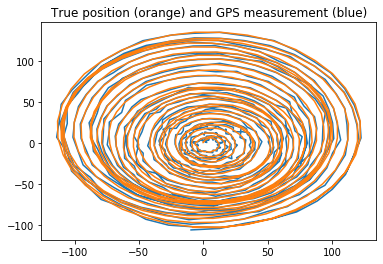

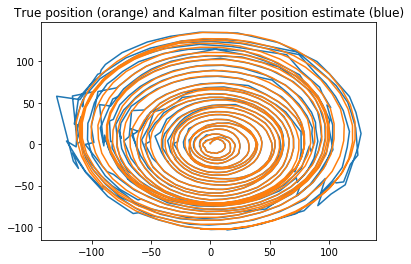

In [15]:
# EKF with AR tag data.  
arx0 = 0
ary0 = 0
arx1 = 10
ary1 = 0
arx2 = 10
ary2 = 10
P_AR_OBSERVED = 0.7
ERROR_AR = 0.1
class ekf:
    def __init__(self, hz):

        self.Q = np.diag([
            0.3,  # variance of location on x-axis | this is really the SD, and same for below, no?
            0.3,  # variance of location on y-axis
            np.deg2rad(25.0),  # variance of yaw angle
            0.5  # variance of velocity
        ]) ** 2  # predict state covariance

        self.R = np.diag([1.3, 1.3, 0.5, ERROR_AR, ERROR_AR, ERROR_AR]) ** 2 # Assuming that the SD is in Metres? 

        self.dt = 1.0/hz    # window of time to which a set of measurements applies
        self.hz = hz
        #self.GPSVisualiser = GPSVisualiser()
        #self.odomPublisher = odomPublisher()

    def motion_model(self, x, u):
        """ Predict then next state of the system given the past state and a model
        :param x: [x, y, yaw, v],
        :param u: [[v]
                [yawrate]]
        :return:
        """
        F = np.array([[1.0, 0, 0, 0],
                      [0, 1.0, 0, 0],
                      [0, 0, 1.0, 0],
                      [0, 0, 0, 0]])
              
        # dimensions are 4 x 2. 
        # so u.T is 2 x 1. Makes sense, ends up w 4x1.
        B = np.array([[self.dt * math.sin(x[2, 0]), 0], # time interval by cosine of yaw. Essentially the horizontal distance component of the velocity vector, when the velocity is 1 at the current orientation.  
                      [self.dt * math.cos(x[2, 0]), 0], # vertical distance component, but why in this matrix form?
                      [0.0, self.dt],   # time interval
                      [1.0, 0.0]])  # to set velocity to the new velocity? 
        x1 = np.matmul(F, x)    # keep position and yaw, but remove velocity. 
        x2 = np.matmul(B, u.T)  # Get the change in x and y, and the change in yaw, as well as the new velocity.
        # updates the x, y and yaw according to the motion model
        retval = x1+x2
        retval[2] = retval[2] % (2 * math.pi)
        return x1+x2

    
    def observation_model2(self, x, z_a):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ])

        z = np.matmul(H, x)

        return z

    def observation_model(self, x, z_available):
        # what comes in from the observation? a 4d vector somehow, of which we need the first three elements.
        z = np.array([[x[0,0], x[1,0], x[2,0], 
            math.sqrt((x[0,0] - arx0)**2 + (x[1,0] - ary0)**2), 
            math.sqrt((x[0,0] - arx1)**2 + (x[1,0] - ary1)**2),
            math.sqrt((x[0,0] - arx2)**2 + (x[1,0] - ary2)**2)]])

        return z[:, z_available].T
    
    def jacobF(self, x, u):
        """
        Jacobian of Motion Model
        motion model
        x_{t+1} = x_t+v*dt*cos(yaw)
        y_{t+1} = y_t+v*dt*sin(yaw)
        yaw_{t+1} = yaw_t+omega*dt
        v_{t+1} = v{t}
        so
        dx/dyaw = -v*dt*sin(yaw)
        dx/dv = dt*cos(yaw)
        dy/dyaw = v*dt*cos(yaw)
        dy/dv = dt*sin(yaw) 
        """
        yaw = x[2, 0]
        v = u[0, 0]
        jF = np.array([
            [1.0, 0.0, self.dt * v * math.cos(yaw), -self.dt * math.sin(yaw)],
            [0.0, 1.0, self.dt * v * math.sin(yaw), self.dt * math.cos(yaw)],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]])

        return jF

    def jacobH(self, x, z_available):
        # Jacobian of Observation Model
        """
        x,y,yaw,d0,d1,d2,a0,a1,a2
        [1,0,0,0]
        [0,1,0,0]
        [0,0,1,0]
        ((x-d0x)^2 + (y-d0y)^2)^1/2
        ((x-d1x)^2 + (y-d1y)^2)^1/2
        ((x-d2x)^2 + (y-d2y)^2)^1/2
        
        """
        jH = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [(x[0,0]-arx0)/math.sqrt((x[0,0]-arx0)**2 + (x[1,0]-ary0)**2),(x[1,0]-ary0)/math.sqrt((x[0,0]-arx0)**2 + (x[1,0]-ary0)**2),0,0], #AR tag 0 d 
            [(x[0,0]-arx1)/math.sqrt((x[0,0]-arx1)**2 + (x[1,0]-ary1)**2),(x[1,0]-ary1)/math.sqrt((x[0,0]-arx1)**2 + (x[1,0]-ary1)**2),0,0], #AR tag 1 d
            [(x[0,0]-arx2)/math.sqrt((x[0,0]-arx2)**2 + (x[1,0]-ary2)**2),(x[1,0]-ary2)/math.sqrt((x[0,0]-arx2)**2 + (x[1,0]-ary2)**2),0,0] #AR tag 2 d

        ])

        return jH[z_available]

    def ekf_estimation(self, xEst, PEst, z, u):
        """
        :param xEst: The estimated state of the rover
        :param PEst: Covariance of the state
        :param z: measurements with noise
        :param z_available: which measurements are available? An array of indices into z.
        :param u: Control input with noise
        :return: xEst and PEst
        """

        #  Predict
        xPred = self.motion_model(xEst, u)  # here we predict the state based on previous state.
        jF = self.jacobF(xPred, u)  # here we get the jacobian of the model function, F. 

        PPred = np.matmul(np.matmul(jF, PEst),jF.T) + self.Q    #Here we calculate the covariance of the prediction xPred. Great. 

        #  Update

        # find out which measurements are not None
        z_available = np.array([i for i in range(z.size) if z[0,i] is not None])

        jH = self.jacobH(xPred, z_available) # Here we get the jacobian of the state -> measurement function, which in this case isn't really a jacobian but a constant. 
        zPred = self.observation_model(xPred, z_available)   # Here we predict the measurements based on our xPred. 
        y = (z[0,z_available] - zPred.T).astype(np.float) # Seems to be the difference between the original measurement and the predicted measurement. 

        S = np.matmul(np.matmul(jH, PPred), jH.T) + self.R[z_available[:, None], (z_available)]  #   The covariance of the prediction xPred, i.e. the model's guess of the state, is transformed into the covariance of the measurement prediction, plus the covariance of error in measurement. 
        K = np.matmul(np.matmul(PPred, jH.T), np.linalg.inv(S)) #This is just the Kalman gain. 

        tmp = np.matmul(K, y.T) # and we multiply by the difference between z observed and the predicted z, per the equation to yield the updated estimate. Not sure why that's not just done in the line below.  

        xEst = xPred + tmp  # completing the formula
        xEst[2] = xEst[2] % (math.pi * 2)
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K, jH)), PPred) # formula for the covariance update, but factorised for simplicity.  
        return xEst, PEst   

    def runFilter(self, visualizeGps=False):
        x = np.zeros((4, 1))
        x_real = np.zeros((4, 1))
        p = np.eye(4)
        rate = 10

        estimate_data = ([],[])
        true_data = [[],[]]
        gps_data = [[], []]
        u = np.array([[10,np.deg2rad(10)/self.dt]])
        for _ in range(1000):
            x_real, x_update = self.simulateFakeDataMeasurement(x_real[0],x_real[1],x_real[2], u) 
            z = x_update.T

            x, p = self.ekf_estimation(x, p, z, u)

            u = np.array([[u[0,0]+0.2,np.deg2rad(10)/self.dt]])

            estimate_data[0].append(x[0,0])
            estimate_data[1].append(x[1,0])
            true_data[0].append(x_real[0])
            true_data[1].append(x_real[1])
            gps_data[0].append(x_update[0])
            gps_data[1].append(x_update[1])

        return estimate_data, true_data, gps_data

    def simulateFakeDataMeasurement(self,x,y,theta,u):
        """
        I want the rover to move in circles.
        """
        x_pos_real = x + u[0,0] * self.dt * math.sin(theta) + np.random.normal(0, 0.3)
        x_pos = x_pos_real + np.random.normal(0, 1.3)# previous x plus a movement plus noise (from measurement)
        y_pos_real = y + u[0,0] * self.dt * math.cos(theta) + np.random.normal(0, 0.3)
        y_pos = y_pos_real + np.random.normal(0, 1.3)# previous y plus a movement plus noise (from measurement)
        theta_pos_real = (theta + u[0,1] * self.dt) % (math.pi * 2) # increases by 10 degrees 
        theta_pos = (theta_pos_real + np.random.normal(0,0.5)) % (math.pi * 2)

        ar0d_real = None
        ar0d = None
        if random.random() < P_AR_OBSERVED:
            ar0d_real = math.sqrt((x_pos_real - arx0)**2 + (y_pos_real - ary0)**2)
            ar0d = ar0d_real + np.random.normal(0, ERROR_AR)
        
        ar1d_real = None
        ar1d = None
        if random.random() < P_AR_OBSERVED:
            ar1d_real = math.sqrt((x_pos_real - arx1)**2 + (y_pos_real - ary1)**2)
            ar1d = ar1d_real + np.random.normal(0, ERROR_AR)

        ar2d_real = None
        ar2d = None
        if random.random() < P_AR_OBSERVED:
            ar2d_real = math.sqrt((x_pos_real - arx2)**2 + (y_pos_real - ary2)**2)
            ar2d = ar2d_real + np.random.normal(0, ERROR_AR)
        

        return np.array([x_pos_real, y_pos_real, theta_pos_real, [ar0d_real], [ar1d_real], [ar2d_real]]), np.array([x_pos, y_pos, theta_pos, [ar0d], [ar1d], [ar2d]])   

if __name__ == '__main__':
    error = []
    #for i in range(0, 100, 5):
    i = 100
    P_AR_OBSERVED = i / 100
    EKF = ekf(10)
    est_data, true_data, gps_data = EKF.runFilter()
    plt.figure()
    plt.plot(gps_data[0], gps_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and GPS measurement (blue)")
    plt.figure()
    plt.plot(est_data[0], est_data[1])
    plt.plot(true_data[0], true_data[1])
    plt.title("True position (orange) and Kalman filter position estimate (blue)")

    print("Average error per time-step with position and AR tag distances: ")



        # compute some form of the RMSE for the kalman estimate and for the GPS only estimate. 
    avg_error_kalman = (np.average(((np.array(est_data[0]) - np.squeeze(np.array(true_data[0])).astype(np.float))**2)) + np.average(((np.array(est_data[1]) - np.squeeze(np.array(true_data[1])).astype(np.float))**2)))/2

    avg_error_gps = (np.average(((np.array(gps_data[0]).astype(np.float) - np.array(true_data[0]).astype(np.float))**2)) + np.average(((np.array(gps_data[1]).astype(np.float) - np.array(true_data[1]).astype(np.float))**2)))/2
    error.append(avg_error_kalman)
    print("Kalman, + AR: ", avg_error_kalman)
    print("Pose only: ", avg_error_gps)
